In [1]:
%matplotlib inline
from __future__ import print_function
from keras.models import Model, Sequential
from keras.engine.training import slice_X
from keras.layers import Lambda, Flatten, Permute, Reshape, Input
from keras.layers import merge, Merge, Activation, TimeDistributed, Dense, RepeatVector, recurrent
import numpy as np
from six.moves import range
import keras.backend as K
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib.cm as cm
from scipy.special import expit

Using Theano backend.


In [2]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, chars, maxlen):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [27]:
# Parameters for the model and dataset
TRAINING_SIZE = 5000
DIGITS = 2
OPS = 2
INVERT = True
# Try replacing GRU, or SimpleRNN
RNN = recurrent.LSTM
HIDDEN_SIZE = 32
BATCH_SIZE = 128
LAYERS = 1
MAXLEN = OPS * DIGITS + OPS - 2

In [28]:
chars = '0123456789+ '
ctable = CharacterTable(chars, MAXLEN)

In [175]:
def generate_data(training_size, num_digits, num_ops):
    questions = []
    expected = []
    seen = set()
    print('Generating data... ')
    while len(questions) < training_size:
#         f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, num_digits + 1))))
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(num_digits)))
        ops = []
        for i in range(num_ops):
            ops.append(f())
                    
        # Skip any addition questions we've already seen
        # Also skip any such that X+Y == Y+X (hence the sorting)
        ops.sort()
        key = tuple(ops)
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN
        q = ''.join([str(op) for op in ops])
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(sum(ops))
        # Answers can be of maximum size DIGITS + 1
        if INVERT:
            query = query[::-1]
            ans = ans[::-1]
        ans += ' ' * (num_digits + 1 - len(ans))
        questions.append(query)
        expected.append(ans)
#         print(len(questions))
    print('Total addition questions:', len(questions))
    
    return questions, expected

In [30]:
def create_train_valid(questions, expected, num_digits, num_ops):
    print('Vectorization...')
    X = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
    y = np.zeros((len(questions), num_digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        X[i] = ctable.encode(sentence, maxlen=MAXLEN)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, maxlen=num_digits + 1)

    # Shuffle (X, y) in unison as the later parts of X will almost all be larger digits
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Explicitly set apart 10% for validation data that we never train over
    split_at = len(X) - len(X) / 10
    (X_train, X_val) = (slice_X(X, 0, split_at), slice_X(X, split_at))
    (y_train, y_val) = (y[:split_at], y[split_at:])

    print(X_train.shape)
    print(y_train.shape)
    
    return X_train, y_train, X_val, y_val

In [31]:
def build_model(hidden_size, num_layers, num_digits, num_ops):
    # Most simple seq2seq model using encoder-decoder framework
    print('Build model...')
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = RNN(hidden_size, input_shape=(MAXLEN, len(chars)))
    model.add(encoder)
    # For the decoder's input, we repeat the encoded input for each time step
    model.add(RepeatVector(num_digits + 1))
    # The decoder RNN could be multiple layers stacked or a single layer
    for _ in range(num_layers):
        decoder = RNN(hidden_size, return_sequences=True)
        model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    mapper = TimeDistributed(Dense(len(chars)))
    model.add(mapper)
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    encoder_f = K.function(inputs, [encoder.output])
    decoder_f = K.function(inputs, [decoder.output])
    mapper_f = K.function(inputs, [mapper.output])
    
    return model, encoder_f, decoder_f, mapper_f, encoder, decoder, mapper

In [214]:
import theano.tensor as T

def get_last_Y(X):
    return X[:, -1, :]

def get_Y(X, xmaxlen):
    return X[:, :xmaxlen, :]  # get first xmaxlen elem from time dim

def get_R(X):
    Y, alpha = X[0], X[1]
    ans = K.T.batched_dot(Y, alpha)
    return ans

def get_R_shape(input_shape):
    shape = list(input_shape)
    outshape = (shape[0][0],shape[0][1])
    return tuple(outshape)

def stack_R(X):
    r_1, r_2, r_3 = X[0], X[1], X[2]
    ans = K.concatenate([r_1, r_2, r_3], axis=1)
    return ans

def get_stack_R_shape(input_shape):
    shape = list(input_shape)
    outshape = (shape[0][0],3,shape[0][2])
    return tuple(outshape)

def stack_decoder_input(X):
    Y, r = X[0], X[1]
    ans = K.concatenate([Y, r], axis=2)
    return ans

def stack_decoder_input_shape(input_shape):
    shape = list(input_shape)
    outshape = (shape[0][0], shape[0][1], shape[0][2]+shape[1][2])
    return tuple(outshape)

def build_att_seq2seq_model(hidden_size, num_layers, num_digits, num_ops, chars):    
    main_input = Input(shape=(MAXLEN,len(chars)), name='main_input')
    encoder = RNN((num_digits+1)*hidden_size, 
                  input_shape=(MAXLEN, len(chars)),
                  return_sequences=True)(main_input)
#     Y = Lambda(get_Y, arguments={"xmaxlen": MAXLEN}, name="Y", output_shape=(MAXLEN, hidden_size))(encoder)
    
    last_Y = Lambda(get_last_Y, name="last_Y", output_shape=((num_digits+1)*hidden_size,))(encoder)
    Y = Reshape((num_digits+1, hidden_size))(last_Y)
    
    WY1 = TimeDistributed(Dense(len(chars)), name="WY1")(main_input)
    WY2 = TimeDistributed(Dense(len(chars)), name="WY2")(main_input)
    WY3 = TimeDistributed(Dense(len(chars)), name="WY3")(main_input)

#     WY2 = TimeDistributed(Dense(hidden_size), name="WY2")(Y)
#     WY3 = TimeDistributed(Dense(hidden_size), name="WY3")(Y)
    M1 = Activation('tanh', name="M1")(WY1)
    M2 = Activation('tanh', name="M2")(WY2)
    M3 = Activation('tanh', name="M3")(WY3)
#     M2 = Activation('tanh', name="M2")(WY2)
#     M3 = Activation('tanh', name="M3")(WY3)

    alpha_1 = TimeDistributed(Dense(1, activation='linear'), name="alpha_1")(M1)
    alpha_2 = TimeDistributed(Dense(1, activation='linear'), name="alpha_2")(M2)
    alpha_3 = TimeDistributed(Dense(1, activation='linear'), name="alpha_3")(M3)
    flat_alpha1 = Flatten(name="flat_alpha1")(alpha_1)
    flat_alpha2 = Flatten(name="flat_alpha2")(alpha_2)
    flat_alpha3 = Flatten(name="flat_alpha3")(alpha_3)
    alpha1 = Dense(MAXLEN, activation='softmax', name="alpha1")(flat_alpha1)
    alpha2 = Dense(MAXLEN, activation='softmax', name="alpha2")(flat_alpha2)
    alpha3 = Dense(MAXLEN, activation='softmax', name="alpha3")(flat_alpha3)

    Y_trans = Permute((2, 1), name="y_trans")(Y)  # of shape (None,300,20)
    Input_trans = Permute((2, 1), name="input_trans")(main_input)

    r_1 = merge([Input_trans, alpha1], output_shape=get_R_shape, name="r_1", mode=get_R)
    r_2 = merge([Input_trans, alpha2], output_shape=get_R_shape, name="r_2", mode=get_R)
    r_3 = merge([Input_trans, alpha3], output_shape=get_R_shape, name="r_3", mode=get_R)

    r1 = Reshape((1,len(chars)))(r_1)
    r2 = Reshape((1,len(chars)))(r_2)
    r3 = Reshape((1,len(chars)))(r_3)
    
#     r_1_trans = Permute((2, 1))(r1)
#     r_2_trans = Permute((2, 1))(r2)
#     r_3_trans = Permute((2, 1))(r3)

#     r = RepeatVector(num_digits+1)(r_1)
#     r = T.stack([r_1, r_2, r_3])
    r = merge([r1, r2, r3], mode=stack_R, output_shape=get_stack_R_shape)
# #     decoder_input = Permute((2, 1))(r)
    
    decoder_input = merge([Y, r], mode=stack_decoder_input, output_shape=stack_decoder_input_shape)
                
                
                
    decoded_result = RNN(hidden_size, input_shape=(num_digits+1, hidden_size), return_sequences=True)(decoder_input)
    mapping = TimeDistributed(Dense(len(chars)))(decoded_result)
    out = Activation('softmax')(mapping)
    
    output = out
    model = Model(input=[main_input], output=output)
#     model = Model(input=[main_input], output=r)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    a1 = model.get_layer('alpha1')
    a2 = model.get_layer('alpha2')
    a3 = model.get_layer('alpha3')
    alpha1_f = K.function(inputs, [a1.output])
    alpha2_f = K.function(inputs, [a2.output])
    alpha3_f = K.function(inputs, [a3.output])

    return model, alpha1_f, alpha2_f, alpha3_f, a1, a2, a3

In [33]:
from keras.layers import Reshape

def build_seq_model(hidden_size, num_layers, num_digits, num_ops):
    # Most simple seq2seq model using encoder-decoder framework
    print('Build model...')
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = RNN(hidden_size*(num_digits+1), input_shape=(MAXLEN, len(chars)))
    model.add(encoder)
    # For the decoder's input, we repeat the encoded input for each time step
    model.add(Reshape((num_digits+1, hidden_size)))
    # The decoder RNN could be multiple layers stacked or a single layer
    for _ in range(num_layers):
        decoder = RNN(hidden_size, return_sequences=True)
        model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    mapper = TimeDistributed(Dense(len(chars)))
    model.add(mapper)
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    encoder_f = K.function(inputs, [encoder.output])
    decoder_f = K.function(inputs, [decoder.output])
    mapper_f = K.function(inputs, [mapper.output])
    
    return model, encoder_f, decoder_f, mapper_f, encoder, decoder, mapper

In [34]:
from keras.layers import Input, merge, TimeDistributedDense
from keras.models import Model

def feedback_model(hidden_size, num_layers, num_digits, num_ops):
    ## Alternative model architecture
    encoder_input = Input(shape=(MAXLEN, len(chars)), name = 'encoder_input')
    decoder_input = Input(shape=(num_digits + 1, len(chars)), name = 'decoder_input')

    x = RNN(hidden_size)(encoder_input)
    context_input = RepeatVector(num_digits + 1)(x)
    x = merge([context_input, decoder_input], mode='concat')
    x = RNN(hidden_size, return_sequences=True)(x)

#     loss = TimeDistributed(Dense(len(chars), activation='softmax'))(x)
    loss = TimeDistributedDense(len(chars), activation='softmax')(x)
    
    model_alt = Model(input=[encoder_input, decoder_input], output=[loss])
    model_alt.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model_alt

In [35]:
def learning(model, X_train, y_train, iterations, X_val, y_val):
    y_true = []
    for idx in range(y_val.shape[0]):
        y_true.append(ctable.decode(y_val[idx]))

#     val_acc_array = []
#     # Train the model each generation and show predictions against the validation dataset
#     for iteration in range(1, iterations):
#         print()
#         print('-' * 50)
#         print('Iteration', iteration)
#         training_obj = model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=1,
#                   validation_data=(X_val, y_val))
#         ###
#         # Select 10 samples from the validation set at random so we can visualize errors
#     #     for i in range(10):
#     #         ind = np.random.randint(0, len(X_val))
#     #         rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
#     #         preds = model.predict_classes(rowX, verbose=0)
#     #         q = ctable.decode(rowX[0])
#     #         correct = ctable.decode(rowy[0])
#     #         guess = ctable.decode(preds[0], calc_argmax=False)
#     #         print('Q', q[::-1] if INVERT else q)
#     #         print('T', correct)
#     #         print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)
#     #         print('---')

# #         preds = model.predict_classes(X_val, verbose=0)
# #         y_preds = []
# #         for idx in range(preds.shape[0]):
# #             y_preds.append(ctable.decode(preds[idx], calc_argmax=False))

# #         acc = accuracy_score(y_true, y_preds)
#         acc = training_obj.history['val_acc']
#         val_acc_array.append(acc)
#         print('Current validation accuracy = ' + str(acc))
    
#     return val_acc_array
    training_obj = model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=iterations,
        validation_data=(X_val, y_val))

In [233]:
DIGITS = 2
OPS = 2
TRAINING_SIZE = 5000
questions, expected = generate_data(TRAINING_SIZE, DIGITS, OPS)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, DIGITS, OPS)
# model, encoder_f_, decoder_f_, mapper_f_, encoder, decoder, mapper = build_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
# model, encoder_f_, decoder_f_, mapper_f_, encoder, decoder, mapper = build_att_seq2seq_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS, chars)
# val_acc_2_2 = learning(model, X_train, y_train, 50, X_val, y_val)
model, alpha1_f, alpha2_f, alpha3_f, aplha1, alpha2, alpha3 = build_att_seq2seq_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS, chars)
# val_acc_2_2 = learning(model, X_train, y_train, 100, X_val, y_val)
learning(model, X_train, y_train, 30, X_val, y_val)

# y_train_pre = np.zeros(y_train.shape)
# for idx in range(len(y_train_pre)):
#     y_train_pre[idx][1:] = y_train[idx][:-1]
# y_val_pre = np.zeros(y_val.shape)
# for idx in range(len(y_val_pre)):
#     y_val_pre[idx][1:] = y_val[idx][:-1]
    
# fb_model = feedback_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
# fb_val_acc_2_2 = learning(fb_model, [X_train, y_train_pre], y_train, 50, [X_val, y_val_pre], y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 4, 12)
(4500, 3, 12)
Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 3s - loss: 2.2684 - acc: 0.2861 - val_loss: 1.9646 - val_acc: 0.3540
Epoch 2/30
4500/4500 [==============================] - 3s - loss: 1.7794 - acc: 0.3490 - val_loss: 1.6627 - val_acc: 0.3660
Epoch 3/30
4500/4500 [==============================] - 4s - loss: 1.6321 - acc: 0.3848 - val_loss: 1.5968 - val_acc: 0.3740
Epoch 4/30
4500/4500 [==============================] - 3s - loss: 1.5844 - acc: 0.3908 - val_loss: 1.5510 - val_acc: 0.3940
Epoch 5/30
4500/4500 [==============================] - 3s - loss: 1.5506 - acc: 0.4096 - val_loss: 1.5252 - val_acc: 0.4147
Epoch 6/30
4500/4500 [==============================] - 3s - loss: 1.5174 - acc: 0.4308 - val_loss: 1.4930 - val_acc: 0.4353
Epoch 7/30
4500/4500 [==============================] - 4s - loss: 1.4884 - acc: 0.4410 - val_loss: 1.4504 

In [234]:
def alpha1_f_(X):
    # The [0] is to disable the training phase flag
    return alpha1_f([0] + [X])

def alpha2_f_(X):
    # The [0] is to disable the training phase flag
    return alpha2_f([0] + [X])

def alpha3_f_(X):
    # The [0] is to disable the training phase flag
    return alpha3_f([0] + [X])

In [235]:
X_str = '1354'
X_str = X_str[::-1]
print(X_str)
X = ctable.encode(X_str, maxlen=MAXLEN).reshape([1,4,12])
preds = model.predict(X, verbose=0)
y_hat = preds[0].argmax(axis=-1)
''.join(ctable.indices_char[x] for x in y_hat)# ctable.indices_char[x]

4531


'76 '

In [236]:
a1 = alpha1_f_(X)
a2 = alpha2_f_(X)
a3 = alpha3_f_(X)

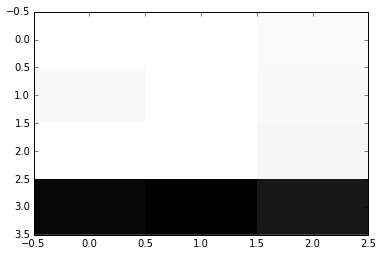

In [237]:
alphas = np.concatenate((a1[0], a2[0], a3[0]))
pl.imshow(np.transpose(alphas), interpolation='none', cmap=cm.binary, aspect='auto')
plt.show()

In [220]:
a1[0]

array([[ 0.00245195,  0.46754903,  0.07227816,  0.45772087]])

In [32]:
a2[0]

array([[  2.67041255e-06,   2.02052330e-07,   4.38094029e-06,
          9.99992747e-01]])

In [33]:
a3[0]

array([[  4.75605568e-10,   9.92902155e-01,   7.09717751e-03,
          6.67429121e-07]])